## Финальный проект: вариант 3

Представьте, что вы работаете в крупном дейтинговом приложении.

Помимо базовых функций, в приложении также имеется премиум-подписка, которая дает доступ к ряду важных дополнительных возможностей. Был проведен A/B тест, в рамках которого для новых пользователей из нескольких стран была изменена стоимость премиум-подписки* при покупке через две новые платежные системы. При этом стоимость пробного периода оставалась прежней.

- Проверьте:

Был ли эксперимент успешен в целом.
Проанализируйте, имеет ли нововведение смысл среди каких-либо конкретных групп пользователей.
Деньги за подписку списываются ежемесячно до тех пор, пока пользователь её не отменит.

- Данные:

Всего есть три группы: тестовая (test), контрольная 1 (control_1) и контрольная 2 (control_2). Для каждой из них:

- #### users_*.csv – информация о пользователях:

    - uid – идентификатор пользователя
    - age – возраст
    - attraction_coeff – коэффициент привлекательности (от 0 до 1000, \frac{лайки}{просмотры}*1000 
просмотры
лайки
​	
 ∗1000)
    - coins – число монеток (внутренняя валюта)
    - country – страна  
    - visit_days – в какие дни после регистрации пользователь посещал приложение (напр. в 1, затем в 7)
    - gender – пол
    - age_filter_start  – фильтр поиска, мин. значение 
    - age_filter_end  – фильтр поиска, макс. значение 
    - views_count – число полученных оценок 
    - was_premium – был ли когда-либо премиум (либо пробный период премиум-статуса, либо купленный за деньги)
    - is_premium –  является ли премиум
    - total_revenue – нормированная выручка

- #### transactions_*.csv – информация о платежах пользователей:

    - uid – идентификатор пользователя
    - country – страна
    - joined_at – дата и время регистрации
    - paid_at – дата и время покупки
    - revenue – нормированная выручка
    - payment_id – идентификатор платежа
    - from_page – откуда пользователь перешел на страницу оплаты
    - product_type – тип продукта (trial_premium – пробная премиум-подписка, premium_no_trial – премиум-подписка без пробной, coins – подписка за внутреннюю валюту, other_type – другое)

 - #### Файлы:

- users_test – информация о пользователях в тестовой группе
- users_control_1 – информация о пользователях в первой контрольной группе
- users_control_2 – информация о пользователях во второй контрольной группе 
- transactions_test – информация о платежах пользователей в тестовой группе
- transactions_control_1 – информация о платежах пользователей в первой контрольной группе
- transactions_control_2 – информация о платежах пользователей во второй контрольной группе 


In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from tqdm.auto import tqdm
from scipy.stats import norm
import seaborn as sns
import warnings
from datetime import datetime

%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
dataset_urls = ['https://stepik.org/media/attachments/lesson/409320/users_test.csv',
         'https://stepik.org/media/attachments/lesson/409320/users_control_1.csv',
         'https://stepik.org/media/attachments/lesson/409320/users_control_2.csv',
         'https://stepik.org/media/attachments/lesson/409320/transactions_test.csv',
         'https://stepik.org/media/attachments/lesson/409320/transactions_control_1.csv',
         'https://stepik.org/media/attachments/lesson/409320/transactions_control_2.csv']

#### Определим функции :

#### A/A test

In [3]:
def a_a_test(subset1,
             subset2,
             n=100000,
             simulations=1000,
             n_s=300,
             estimator=stats.ttest_ind, 
             f='total_revenue'):
    res = []
    if f == 'total_revenue':
        for i in tqdm(range(simulations)):
            s1 = subset1.total_revenue.sample(n_s, replace = False).values
            s2 = subset2.total_revenue.sample(n_s, replace = False).values
            res.append(estimator(s1, s2, equal_var = False)[1])                 
    else:
        for i in tqdm(range(simulations)):
            s1 = subset1.revenue.sample(n_s, replace = False).values
            s2 = subset2.revenue.sample(n_s, replace = False).values
            res.append(estimator(s1, s2, equal_var = False)[1]) 
            
    sns.set(rc={'figure.figsize': (15,7)})
    plt.hist(res, bins=50)
    plt.style.use('ggplot')
    plt.show()

    return(f'Проверяем, что количество ложноположительных случаев не превышает альфа (< 0.05): p-value\
      {sum(np.array(res) < 0.05) / simulations}')

#### Bootstrap

In [4]:
def get_bootstrap(
    subset1, 
    subset2,
    boot_it=2000, 
    statistic=np.mean, 
    bootstrap_conf_level = 0.95,
    caption='boot_data', y = False
):
    boot_len = max(len(subset1), len(subset2))
    boot_data = []
    for i in range(boot_it):
        samples_1 = subset1.sample(boot_len, replace = True ).values
        samples_2 = subset2.sample(boot_len, replace = True).values
        boot_data.append(statistic(samples_1 - samples_2)) 
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level)/2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(x = 0, loc = np.mean(boot_data), scale = np.std(boot_data))
    p_2 = norm.cdf(x = 0, loc = -np.mean(boot_data), scale = np.std(boot_data))
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    if y:
        _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
        for bar in bars:
            if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
                bar.set_facecolor('red')
            else: 
                bar.set_facecolor('grey')
                bar.set_edgecolor('black')

        sns.set(rc={'figure.figsize': (15,7)})
        plt.style.use('ggplot')
        plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
        plt.xlabel('boot_data')
        plt.ylabel('frequency')
        plt.title(f'Histogram of {caption}')
        plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

#### Загрузим данные и проведем разведочный анализ датасетов

In [5]:
dataset_names = [pd.read_csv(i,sep=';') for i in dataset_urls]

In [6]:
(users_test, users_control_1, users_control_2, 
transactions_test, transactions_control_1, transactions_control_2) = dataset_names

In [7]:
# создадим список категорий 
product_types = list(transactions_test.product_type.unique())
country_list = list(transactions_test.country.unique())

In [8]:
# посмотрим на данные 
for i in dataset_names:
    print(i.isna().sum())

uid                    0
age                    0
attraction_coeff       0
coins               4259
country                0
visit_days          1330
gender                 0
age_filter_start       0
age_filter_end         0
views_count            0
was_premium         3900
is_premium          4151
total_revenue          0
dtype: int64
uid                    0
age                    0
attraction_coeff       0
coins               4280
country                0
visit_days          1324
gender                 0
age_filter_start       0
age_filter_end         0
views_count            0
was_premium         3904
is_premium          4148
total_revenue          0
dtype: int64
uid                    0
age                    0
attraction_coeff       0
coins               4203
country                0
visit_days          1364
gender                 0
age_filter_start       0
age_filter_end         0
views_count            0
was_premium         3853
is_premium          4073
total_revenue          0

In [9]:
# Меняем NaN значения на нули в группе 'users'
for i in dataset_names[0:3]:
    i.fillna(0,inplace=True)

In [10]:
# Убирем пустые uid и  дропнем дубликаты в 'transaction'
transactions_control_1.dropna(inplace=True)
transactions_control_1.drop_duplicates(inplace=True)

In [11]:
# посмотрим типы данных
for i in dataset_names:
    print(i.dtypes)

uid                   int64
age                   int64
attraction_coeff      int64
coins               float64
country              object
visit_days           object
gender                int64
age_filter_start      int64
age_filter_end        int64
views_count           int64
was_premium         float64
is_premium          float64
total_revenue         int64
dtype: object
uid                   int64
age                   int64
attraction_coeff      int64
coins               float64
country              object
visit_days           object
gender                int64
age_filter_start      int64
age_filter_end        int64
views_count           int64
was_premium         float64
is_premium          float64
total_revenue         int64
dtype: object
uid                   int64
age                   int64
attraction_coeff      int64
coins               float64
country              object
visit_days           object
gender                int64
age_filter_start      int64
age_filter_end      

In [12]:
# приведем типы
transactions_control_1[['uid','revenue','payment_id']] = transactions_control_1[['uid','revenue','payment_id']]\
                                                                                .astype('int')

####   Посмотрим распределения и визуализируем данные...

### Группа : **'users'**

In [13]:
# и посмотрим статистику прибыли по датасетам users
for dataset in (users_test,users_control_1,users_control_2):
    print(f'{dataset.total_revenue.describe()}')
    print('------------------------')

count      4308.000000
mean        534.080316
std        4371.682632
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max      129870.000000
Name: total_revenue, dtype: float64
------------------------
count      4340.000000
mean        594.761982
std        7987.922925
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max      486330.000000
Name: total_revenue, dtype: float64
------------------------
count     4264.000000
mean       450.384146
std       2859.242228
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      81796.000000
Name: total_revenue, dtype: float64
------------------------


- ***во второй группе максимальное значение вызывает интерес...***

In [14]:
users_control_1.query('total_revenue >= 486330').uid

1427    892333905
Name: uid, dtype: int64

- ***у данного пользователя есть "подозрительные" платежи (дубли, повторы и одновременные транзакции)***

In [15]:

transactions_control_1.query('uid == 892333905')\
                      .groupby(['paid_at','product_type'],as_index=False)\
                      .revenue.sum()            

,paid_at,product_type,revenue
0,2017-10-16 01:42:00,other_type,3783
1,2017-10-16 01:44:00,other_type,3783
2,2017-10-16 01:57:00,other_type,3783
3,2017-10-16 01:58:00,other_type,3783
4,2017-10-16 02:08:00,coins,45396
5,2017-10-16 02:08:00,other_type,3783
6,2017-10-16 02:26:00,coins,31525
7,2017-10-16 02:52:00,coins,31525
8,2017-10-16 10:24:00,coins,31525
9,2017-10-16 13:10:00,premium_no_trial,63037


-***похоже на технические проблемы с логированием...*** 

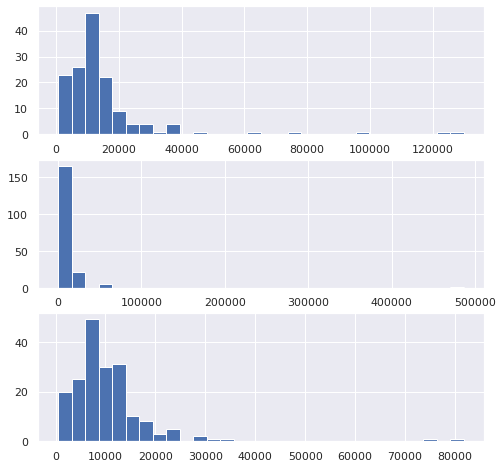

In [116]:
# Посмотрим на распределение 'платящих' пользователей по total_revenue в группе users
sns.set(rc={'figure.figsize': (8,8)})
fig, axes = plt.subplots(3, 1)

users_test.query('total_revenue >0').total_revenue.hist(bins=30, ax=axes[0])
users_control_1.query('total_revenue >0').total_revenue.hist(bins=30, ax=axes[1])
users_control_2.query('total_revenue >0').total_revenue.hist(bins=30, ax=axes[2])


In [17]:
# Посмотрим на количество user'ов с total_revenue выше 30000:
for i in (users_test,users_control_1,users_control_2):
    print(i.query('total_revenue >= 30000').uid.count(), end=';  ')
print()    
print('-'*12)
# 

12;  6;  4;  
------------


In [18]:
# Количество таких пользоватеелей неезначитеельно - уберем outlier'ы
users_t  = users_test.query('total_revenue < 30000')
users_contr_1 = users_control_1.query('total_revenue < 30000')
users_contr_2 = users_control_2.query('total_revenue < 30000')

In [19]:
# проверим статистики повторно
for dataset in (users_t,users_contr_1,users_contr_2):
    print(dataset.total_revenue.describe())
    print('------------------------')

count     4296.000000
mean       361.930168
std       2280.345371
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      28535.000000
Name: total_revenue, dtype: float64
------------------------
count     4334.000000
mean       411.854638
std       2248.616478
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      29081.000000
Name: total_revenue, dtype: float64
------------------------
count     4260.000000
mean       398.596479
std       2194.468833
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      28119.000000
Name: total_revenue, dtype: float64
------------------------


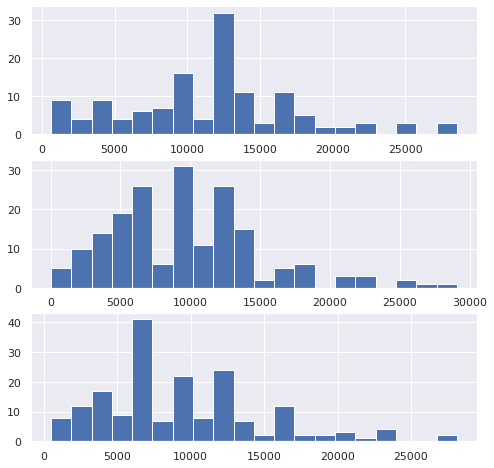

In [114]:
# посмотрим теперь:
sns.set(rc={'figure.figsize': (8,8)})
fig, axes = plt.subplots(3, 1)
users_t.query('total_revenue >0').total_revenue.hist(bins=20, ax=axes[0])
users_contr_1.query('total_revenue >0').total_revenue.hist(bins=20, ax=axes[1])
users_contr_2.query('total_revenue >0').total_revenue.hist(bins=20, ax=axes[2])

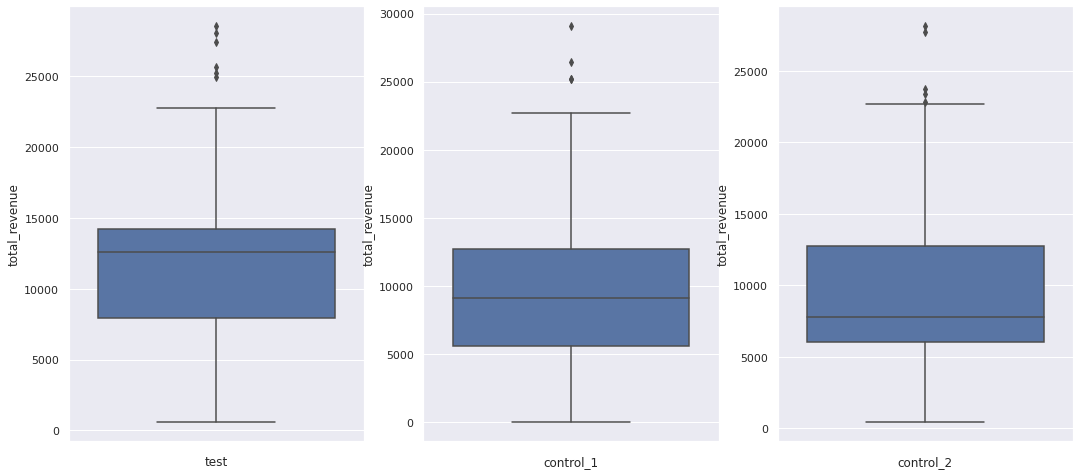

In [21]:
sns.set(rc={'figure.figsize': (18,8)})
fig, axes = plt.subplots(1, 3)

ax = sns.boxplot(data=users_t.query('total_revenue >0'),y='total_revenue',ax=axes[0])
ax.set(xlabel='test')
ax = sns.boxplot(data=users_contr_1.query('total_revenue >0'),y='total_revenue',ax=axes[1]) 
ax.set(xlabel='control_1')
ax = sns.boxplot(data=users_contr_2.query('total_revenue >0'),y='total_revenue',ax=axes[2])  
ax.set(xlabel='control_2')
plt.show()

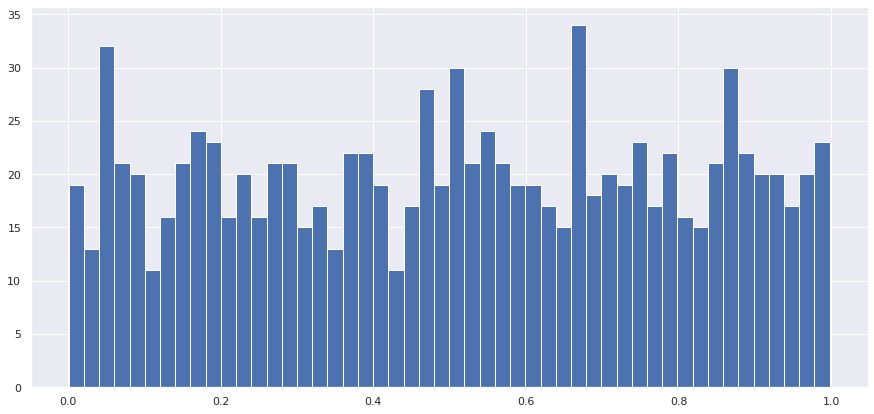

Проверяем, что количество ложноположительных случаев не превышает альфа (< 0.05): p-value      0.046
------------------------------------------------------------------------------------------
Тест сходится


In [22]:
# Проведем А/А тест: сравним контрольные группы
AA_test = a_a_test(users_contr_1,users_contr_2,n_s=500)
print(AA_test)
print('-'*90)
print('Тест сходится' if  float(AA_test.split()[-1])<0.05 else 'Тест не сходится')

### Группа : **'transactions'**

In [23]:
for dataset in (transactions_test,transactions_control_1,transactions_control_2):
    print(dataset.revenue.describe())
    print('------------------------')

count       273.000000
mean       8589.380952
std       11127.479971
min         533.000000
25%        2743.000000
50%        6305.000000
75%       12597.000000
max      113477.000000
Name: revenue, dtype: float64
------------------------
count      356.000000
mean      7007.876404
std       7985.995094
min         26.000000
25%       2804.750000
50%       6292.000000
75%       7312.500000
max      63037.000000
Name: revenue, dtype: float64
------------------------
count      328.000000
mean      5854.993902
std       6582.242539
min        481.000000
25%       2323.750000
50%       4706.000000
75%       6314.750000
max      81796.000000
Name: revenue, dtype: float64
------------------------


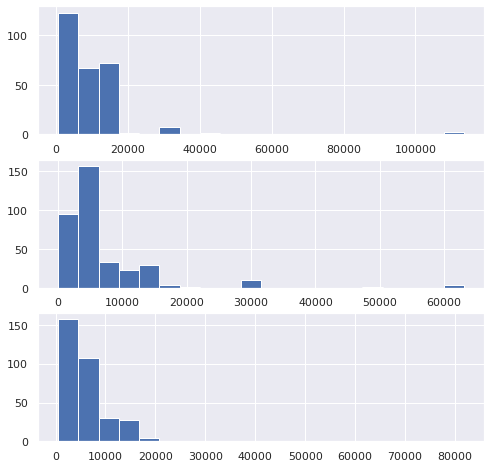

In [117]:
sns.set(rc={'figure.figsize': (8,8)})
fig, axes = plt.subplots(3, 1)

transactions_test.revenue.hist(bins=20, ax=axes[0])
transactions_control_1.revenue.hist(bins=20, ax=axes[1])
transactions_control_2.revenue.hist(bins=20, ax=axes[2])


- ***Графики распределений скошенны вправо - похожая картина с outlier'ами*** 

[Text(0.5, 0, 'control_2')]

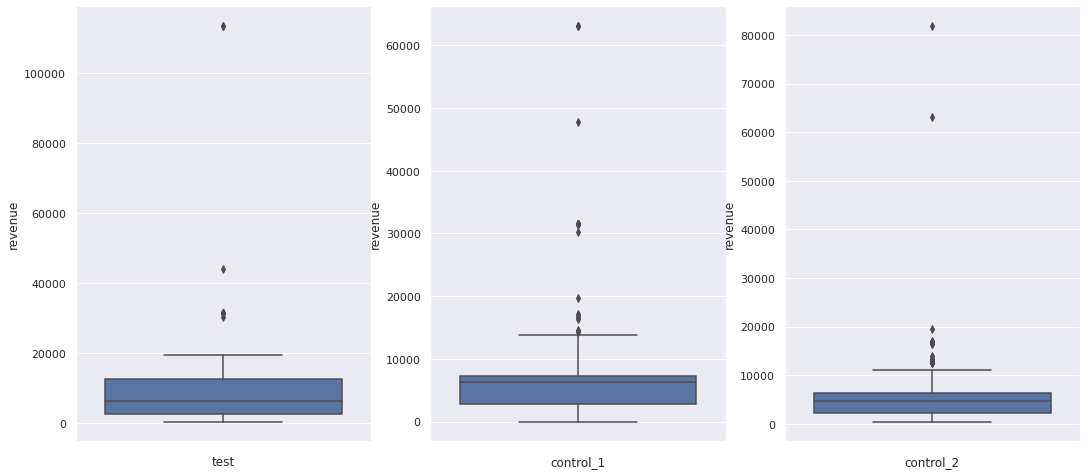

In [25]:
sns.set(rc={'figure.figsize': (18,8)})
fig, axes = plt.subplots(1, 3)

ax = sns.boxplot(data=transactions_test,y='revenue',ax=axes[0])
ax.set(xlabel='test')
ax = sns.boxplot(data=transactions_control_1,y='revenue',ax=axes[1]) 
ax.set(xlabel='control_1')
ax = sns.boxplot(data=transactions_control_2,y='revenue',ax=axes[2])  
ax.set(xlabel='control_2')

- **похоже есть проблеммы с системой сплиттирования...**

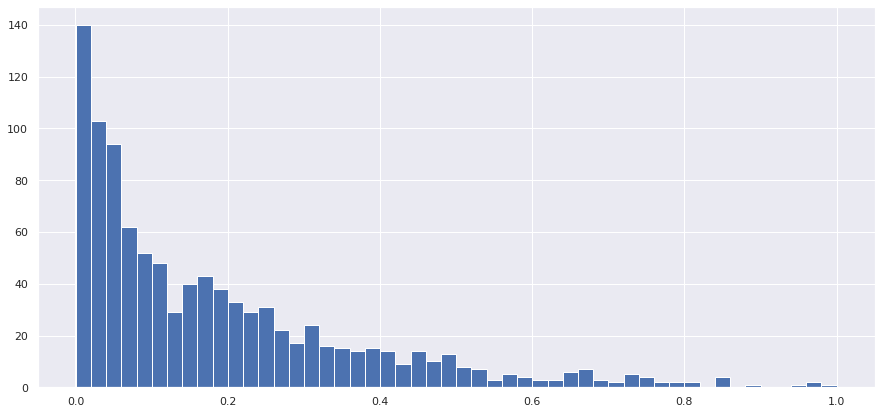

Проверяем, что количество ложноположительных случаев не превышает альфа (< 0.05): p-value      0.295
------------------------------------------------------------------------------------------
Тест не сходится


In [26]:
# Проверим сплит А/А тестом
AA_test = a_a_test(transactions_control_1,transactions_control_2,n_s=200,f='revenue')
print(AA_test)
print('-'*90)
print('Тест сходится' if  float(AA_test.split()[-1])<0.05 else 'Тест не сходится')

In [27]:
# убираем "выбросы"
transactions_contr_1 = transactions_control_1.query('0<revenue<30000')
transactions_contr_2 = transactions_control_2.query('0<revenue<30000')
transactions_t = transactions_test.query('0<revenue<30000')

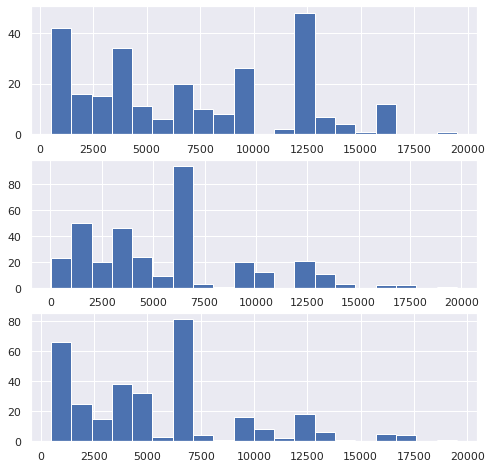

In [118]:
sns.set(rc={'figure.figsize': (8,8)})
fig, axes = plt.subplots(3, 1)

transactions_t.revenue.hist(bins=20, ax=axes[0])
transactions_contr_1.revenue.hist(bins=20, ax=axes[1])
transactions_contr_2.revenue.hist(bins=20, ax=axes[2])


In [29]:
for dataset in (transactions_t,transactions_contr_1,transactions_contr_2):
    print(dataset.revenue.describe())
    print('--------------------------------/')
    

count      263.000000
mean      7051.140684
std       4852.121283
min        533.000000
25%       2736.500000
50%       6305.000000
75%      12597.000000
max      19500.000000
Name: revenue, dtype: float64
--------------------------------/
count      342.000000
mean      5684.154971
std       3834.973886
min         26.000000
25%       2730.000000
50%       5551.000000
75%       6418.750000
max      19773.000000
Name: revenue, dtype: float64
--------------------------------/
count      326.000000
mean      5446.641104
std       3952.173861
min        481.000000
25%       2317.250000
50%       4686.500000
75%       6305.000000
max      19513.000000
Name: revenue, dtype: float64
--------------------------------/


[Text(0.5, 0, 'control_2')]

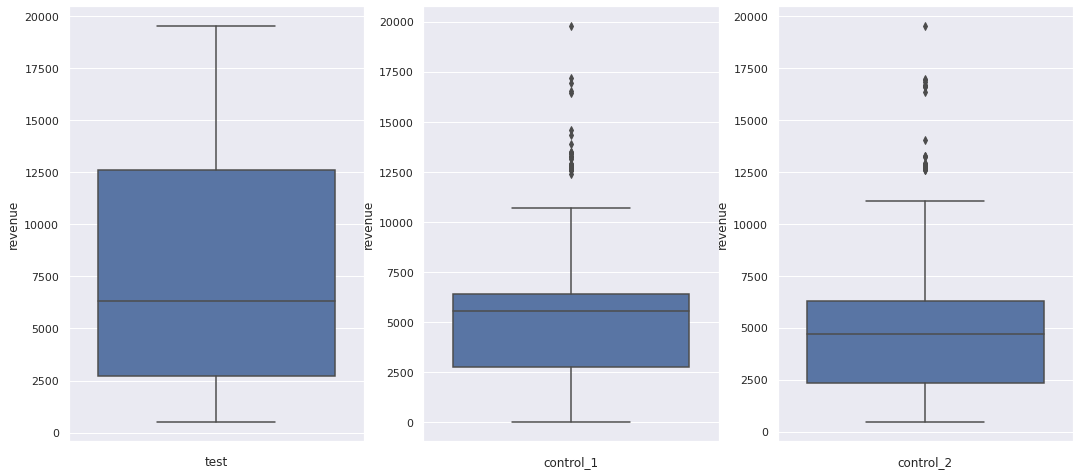

In [30]:
sns.set(rc={'figure.figsize': (18,8)})
fig, axes = plt.subplots(1, 3)

ax = sns.boxplot(data=transactions_t,y='revenue',ax=axes[0])
ax.set(xlabel='test')
ax = sns.boxplot(data=transactions_contr_1,y='revenue',ax=axes[1]) 
ax.set(xlabel='control_1')
ax = sns.boxplot(data=transactions_contr_2,y='revenue',ax=axes[2])  
ax.set(xlabel='control_2')

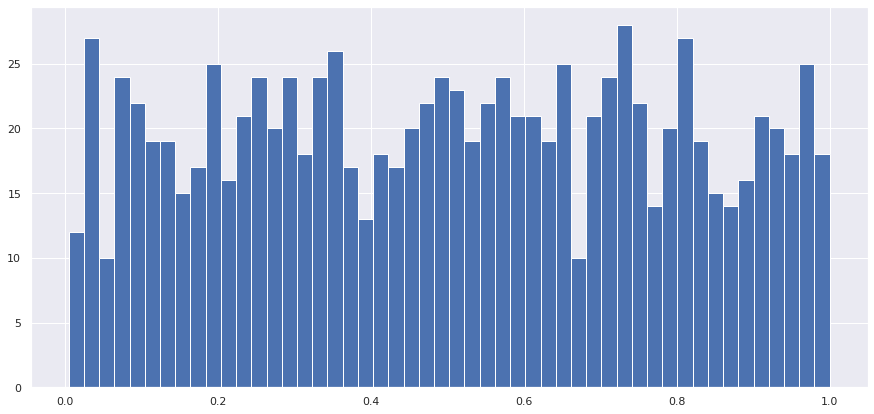

Проверяем, что количество ложноположительных случаев не превышает альфа (< 0.05): p-value      0.04
------------------------------------------------------------------------------------------
Тест сходится


In [31]:
# Проверим сплит А/А тестом
AA_test = a_a_test(transactions_contr_1,transactions_contr_2,n_s=100,f='revenue')
print(AA_test)
print('-'*90)
print('Тест сходится' if  float(AA_test.split()[-1])<0.05 else 'Тест не сходится')

##### Объединим данные в три датасета и прорверим был ли эксперимент успешен в целом. И имеет ли нововведение смысл среди каких-либо конкретных групп пользователей.

In [32]:
trans_control_1 = transactions_contr_1.groupby('uid',as_index=False)\
                                               .agg({'paid_at': 'count','revenue': 'sum'})\
                                               .rename(columns={'paid_at': 'number_purchase'})
trans_control_2 = transactions_contr_2.groupby('uid',as_index=False)\
                                               .agg({'paid_at': 'count','revenue': 'sum'})\
                                               .rename(columns={'paid_at': 'number_purchase'})
trans_test      = transactions_t.groupby('uid',as_index=False)\
                                               .agg({'paid_at': 'count','revenue': 'sum'})\
                                               .rename(columns={'paid_at': 'number_purchase'})

In [33]:
union_test  = users_test[['uid', 'age', 'country', 'visit_days', 'gender', 'total_revenue']]\
                             .merge(trans_test ,on='uid',how='left').fillna(0)

union_control_1 = users_control_1[['uid', 'age', 'country', 'visit_days', 'gender', 'total_revenue']]\
                             .merge(trans_control_1 ,on='uid',how='left').fillna(0)

union_control_2 = users_control_2[['uid', 'age', 'country', 'visit_days', 'gender', 'total_revenue']]\
                             .merge(trans_control_2, on='uid' ,how='left').fillna(0)

##### сравним total_revenue пользователей и sum revenue из транзакций

In [34]:
for i in (union_test,union_control_1,union_control_2):
    print(i.query('total_revenue < revenue ').index)

Int64Index([], dtype='int64')
Int64Index([510], dtype='int64')
Int64Index([], dtype='int64')


In [35]:
union_control_1.loc[510,:].to_frame().T # это же наш соотечественник!

,uid,age,country,visit_days,gender,total_revenue,number_purchase,revenue
510,960936960,30,Russian Federation,"1,2,3,4,7,8,9,10,11,14,15,16,17,18,21,22,23,24...",1,26,3,806


In [36]:
# добавим соотечественннику деньжат соответственно транзакциям :))
union_control_1.loc[510,'total_revenue'] += (
    union_control_1.loc[510,:].revenue - union_control_1.loc[510,:].total_revenue)
union_control_1.loc[510,:].to_frame().T

,uid,age,country,visit_days,gender,total_revenue,number_purchase,revenue
510,960936960,30,Russian Federation,"1,2,3,4,7,8,9,10,11,14,15,16,17,18,21,22,23,24...",1,806,3,806


##### Проверим  стат.значимые различия пользователей в контрольных группах: 

In [37]:
for i in (union_test,union_control_1,union_control_2):
    print(i.revenue.describe())

count     4308.000000
mean       430.466574
std       2804.156327
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      64298.000000
Name: revenue, dtype: float64
count     4340.000000
mean       447.921889
std       2692.232189
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      63024.000000
Name: revenue, dtype: float64
count     4264.000000
mean       416.417683
std       2308.723416
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      34125.000000
Name: revenue, dtype: float64


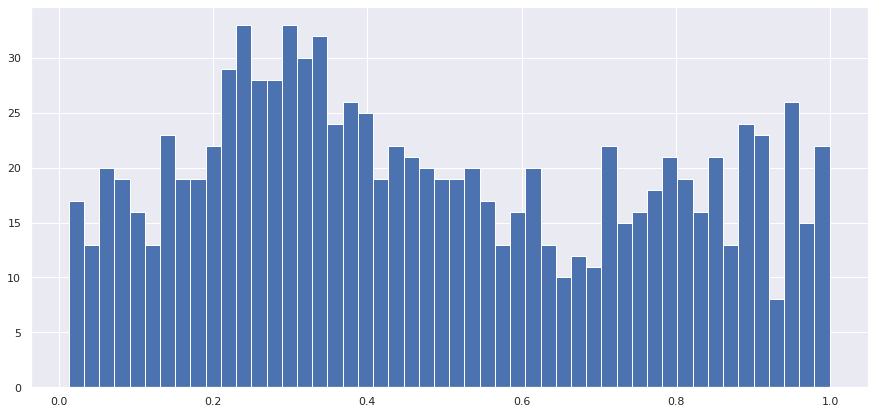

Проверяем, что количество ложноположительных случаев не превышает альфа (< 0.05): p-value      0.028
------------------------------------------------------------------------------------------
Тест сходится


In [38]:
AA_test = a_a_test(union_control_1,union_control_2,n_s=500)
print(AA_test)
print('-'*90)
print('Тест сходится' if  float(AA_test.split()[-1])<0.05 else 'Тест не сходится')

### ИТОГИ:
- **предварительный (разведочный анализ) выявил пропуски, повторы в данных (возможны ошибки в логировании).**
- **характер распределений в двух группах может говорить об ошибки сплиттирования**
- **после преподготовки данных А/А тескт не показал статистически значимых различий между контрольными выборками**
- **(как в users, так и в transactions)**
    

- **Посмотрим на реакцию метрик в выборках test и control_1**

### ARPU, ARPPU, AVG_check (средний чек): 

In [39]:
ARPU = []
for i in (union_test,union_control_1):
    j = round(i.total_revenue.mean(),2)
    ARPU.append(j)

In [40]:
ARPPU = []
for i in (union_test,union_control_1):
    j = round(i.query('total_revenue > 0')['total_revenue'].mean(),2)
    ARPPU.append(j)

In [41]:
AVG_check = []
for i in (trans_test,trans_control_1):
    j = round(i.query('revenue > 0').revenue.mean(),2)
    AVG_check.append(j)

In [42]:
CR = []
for i in (union_test,union_control_1):
    j = round(i.query('total_revenue > 0').uid.count()/i.uid.count(),2)*100
    CR.append(j)    

In [83]:
df = pd.DataFrame({'ARPU': ARPU,'ARPPU': ARPPU,'AVG_check': AVG_check,'CR%':CR}, index=['test_group','control_group'])
df

,ARPU,ARPPU,AVG_check,CR%
test_group,534.08,NaN,NaN,3.0
control_group,594.94,NaN,NaN,4.0


#### Есть следующие изменения : 
- ##### рост прибыли на платящего пользователя и рост среднего чека;
- ##### снижение прибыли на пользователя и конверсии в покупателя;

***Проверим статисттическую значимость различий ...***

### ARPPU

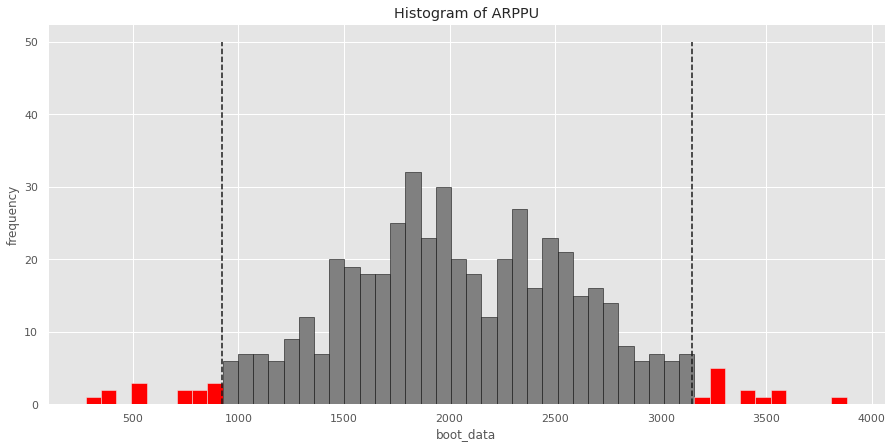

p-value MW : 0.0008
p-value BS : 0.0005
p-value T-test : 0.0021
quants BS :                 0
0.025   921.731452
0.975  3149.868548


In [81]:
data_Control = union_test.query('0<total_revenue<30000').total_revenue
data_Treatment = union_control_1.query('0<total_revenue<30000').total_revenue

booted_data_mean = get_bootstrap(data_Control, data_Treatment,500,np.mean,y=True,caption = 'ARPPU')
print(f'p-value MW : {round(stats.mannwhitneyu(data_Control, data_Treatment)[1],4)}')
print(f'p-value BS : {round(booted_data_mean["p_value"],4)}')
print(f'p-value T-test : {round(stats.ttest_ind(data_Control, data_Treatment)[1],4)}')
print(f'quants BS :{booted_data_mean["quants"]}')

### ARPU

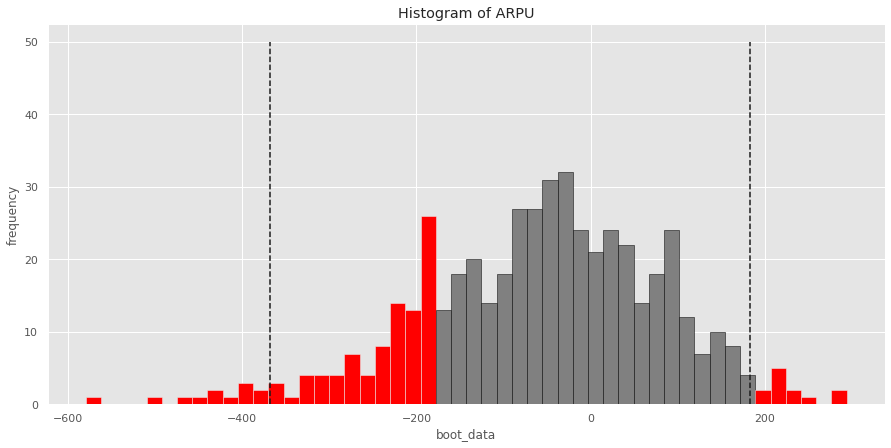

p-value MW : 0.0082
p-value BS : 0.6717
p-value T-test : 0.6606
quants BS :                0
0.025 -368.053065
0.975  182.924603


In [80]:
data_Control = union_test.total_revenue
data_Treatment = union_control_1.total_revenue

booted_data_mean = get_bootstrap(data_Control, data_Treatment,500,np.mean,y=True,caption = 'ARPU')
print(f'p-value MW : {round(stats.mannwhitneyu(data_Control, data_Treatment)[1],4)}')
print(f'p-value BS : {round(booted_data_mean["p_value"],4)}')
print(f'p-value T-test : {round(stats.ttest_ind(data_Control, data_Treatment)[1],4)}')
print(f'quants BS :{booted_data_mean["quants"]}')

### AVG_check

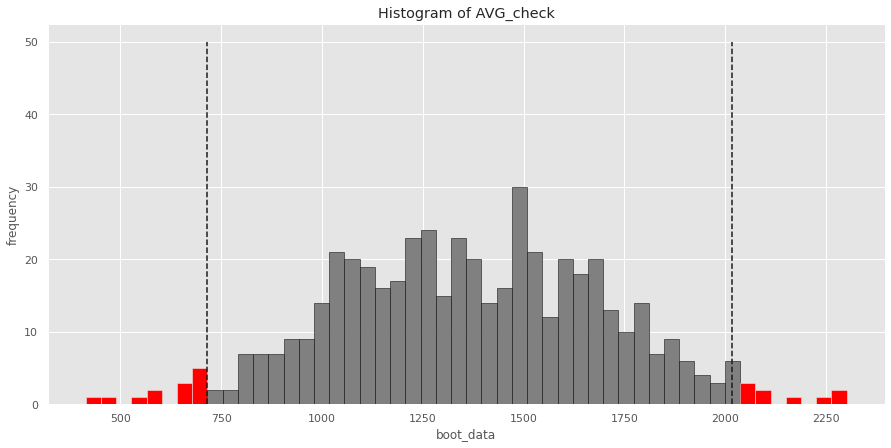

p-value MW : 0.0033
p-value BS : 0.0
p-value T-test : 0.0001
quants BS :                 0
0.025   713.761769
0.975  2016.165058


In [79]:
data_Control = transactions_t.revenue
data_Treatment = transactions_contr_1.revenue

booted_data_mean = get_bootstrap(data_Control, data_Treatment,500,np.mean,y=True,caption = 'AVG_check')
print(f'p-value MW : {round(stats.mannwhitneyu(data_Control, data_Treatment)[1],4)}')
print(f'p-value BS : {round(booted_data_mean["p_value"],4)}')
print(f'p-value T-test : {round(stats.ttest_ind(data_Control, data_Treatment)[1],4)}')
print(f'quants BS :{booted_data_mean["quants"]}')

- ***тесты и статистика показывают стат.значимые различия для метрик AVG_check и ARPPU.***

#### Посмотрим  по типам подписки:

In [47]:
transactions_t.groupby('product_type').agg({'revenue':'sum','uid': pd.Series.nunique}).reset_index()

,product_type,revenue,uid
0,coins,377026,48
1,other_type,93470,18
2,premium_no_trial,583752,65
3,trial_premium,800202,61


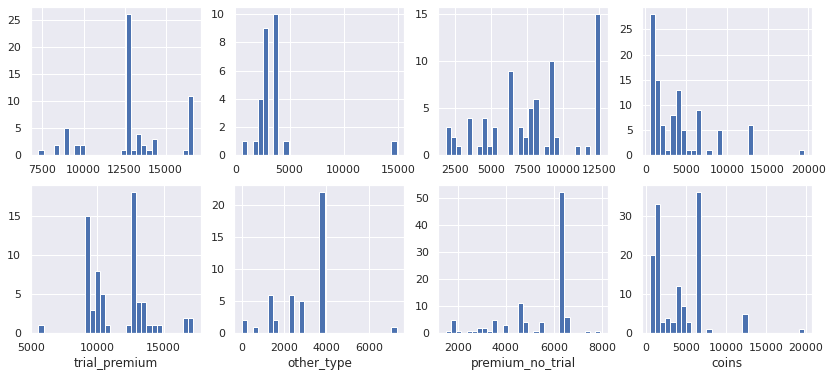

In [121]:
fig, axes = plt.subplots(2, 4)
sns.set(rc={'figure.figsize': (14,6)})
ax = transactions_t.query('product_type == "trial_premium"').revenue.hist(bins=30, ax=axes[0][0])
ax = transactions_contr_1.query('product_type == "trial_premium"').revenue.hist(bins=30, ax=axes[1][0])
ax.set(xlabel='trial_premium')
ax = transactions_t.query('product_type == "other_type"').revenue.hist(bins=30, ax=axes[0][1])
ax = transactions_contr_1.query('product_type == "other_type"').revenue.hist(bins=30, ax=axes[1][1])
ax.set(xlabel='other_type')
ax = transactions_t.query('product_type == "premium_no_trial"').revenue.hist(bins=30, ax=axes[0][2])
ax = transactions_contr_1.query('product_type == "premium_no_trial"').revenue.hist(bins=30, ax=axes[1][2])
ax.set(xlabel='premium_no_trial')
ax = transactions_t.query('product_type == "coins"').revenue.hist(bins=30, ax=axes[0][3])
ax = transactions_contr_1.query('product_type == "coins"').revenue.hist(bins=30, ax=axes[1][3])
ax.set(xlabel='coins')
plt.show()

### 1. product_type == "coins"

#### ARPPU

In [49]:
data_Control = transactions_t.query('revenue > 0 and product_type == "coins"').groupby('uid').revenue.sum()
data_Treatment = transactions_contr_1.query('revenue > 0 and product_type == "coins"').groupby('uid').revenue.sum()

booted_data_mean = get_bootstrap(data_Control, data_Treatment,1000,np.mean,y=False)
print(f'p-value MW : {round(stats.mannwhitneyu(data_Control, data_Treatment)[1],4)}')
print(f'p-value BS : {round(booted_data_mean["p_value"],4)}')
print(f'p-value T-test : {round(stats.ttest_ind(data_Control, data_Treatment)[1],4)}')

p-value MW : 0.4849
p-value BS : 0.8771
p-value T-test : 0.907


#### AVG_check

In [50]:
data_Control = transactions_t.query('product_type == "coins"').revenue
data_Treatment = transactions_contr_1.query('product_type == "coins"').revenue

booted_data_mean = get_bootstrap(data_Control, data_Treatment,1000,np.mean,y=False)
print(f'p-value MW : {round(stats.mannwhitneyu(data_Control, data_Treatment)[1],4)}')
print(f'p-value BS : {round(booted_data_mean["p_value"],4)}')
print(f'p-value T-test : {round(stats.ttest_ind(data_Control, data_Treatment)[1],4)}')

p-value MW : 0.0943
p-value BS : 0.8009
p-value T-test : 0.7941


### 2. product_type == "premium_no_trial"

#### ARPPU

In [51]:
data_Control = transactions_t.query('revenue > 0 and product_type == "premium_no_trial"')\
                             .groupby('uid').revenue.sum()
data_Treatment = transactions_contr_1.query('revenue > 0 and product_type == "premium_no_trial"')\
                                     .groupby('uid').revenue.sum()

booted_data_mean = get_bootstrap(data_Control, data_Treatment,1000,np.mean,y=False)
print(f'p-value MW : {round(stats.mannwhitneyu(data_Control, data_Treatment)[1],4)}')
print(f'p-value BS : {round(booted_data_mean["p_value"],4)}')
print(f'p-value T-test : {round(stats.ttest_ind(data_Control, data_Treatment)[1],4)}')

p-value MW : 0.0
p-value BS : 0.0
p-value T-test : 0.0


#### AVG_check

In [52]:
data_Control = transactions_t.query('revenue > 0 and product_type == "premium_no_trial"').revenue
data_Treatment = transactions_contr_1.query('revenue > 0 and product_type == "premium_no_trial"').revenue

booted_data_mean = get_bootstrap(data_Control, data_Treatment,1000,np.mean,y=False)
print(f'p-value MW : {round(stats.mannwhitneyu(data_Control, data_Treatment)[1],4)}')
print(f'p-value BS : {round(booted_data_mean["p_value"],4)}')
print(f'p-value T-test : {round(stats.ttest_ind(data_Control, data_Treatment)[1],4)}')

p-value MW : 0.0
p-value BS : 0.0
p-value T-test : 0.0


### 3. product_type == "trial_premium"

#### ARPPU

In [53]:
data_Control = transactions_t.query('revenue > 0 and product_type == "trial_premium"')\
                             .groupby('uid').revenue.sum()
data_Treatment = transactions_contr_1.query('revenue > 0 and product_type == "trial_premium"')\
                                     .groupby('uid').revenue.sum()

booted_data_mean = get_bootstrap(data_Control, data_Treatment,1000,np.mean,y=False)
print(f'p-value MW : {round(stats.mannwhitneyu(data_Control, data_Treatment)[1],4)}')
print(f'p-value BS : {round(booted_data_mean["p_value"],4)}')
print(f'p-value T-test : {round(stats.ttest_ind(data_Control, data_Treatment)[1],4)}')

p-value MW : 0.0015
p-value BS : 0.0004
p-value T-test : 0.0008


#### AVG_check

In [54]:
data_Control = transactions_t.query('revenue > 0 and product_type == "trial_premium"').revenue
data_Treatment = transactions_contr_1.query('revenue > 0 and product_type == "trial_premium"').revenue

booted_data_mean = get_bootstrap(data_Control, data_Treatment,1000,np.mean,y=False)
print(f'p-value MW : {round(stats.mannwhitneyu(data_Control, data_Treatment)[1],4)}')
print(f'p-value BS : {round(booted_data_mean["p_value"],4)}')
print(f'p-value T-test : {round(stats.ttest_ind(data_Control, data_Treatment)[1],4)}')

p-value MW : 0.0018
p-value BS : 0.0007
p-value T-test : 0.0012


### 4. product_type == "other_type"

#### ARPPU

In [55]:
data_Control = transactions_t.query('revenue > 0 and product_type == "other_type"')\
                             .groupby('uid').revenue.sum()
data_Treatment = transactions_contr_1.query('revenue > 0 and product_type == "other_type"')\
                                     .groupby('uid').revenue.sum()

booted_data_mean = get_bootstrap(data_Control, data_Treatment,1000,np.mean,y=False)
print(f'p-value MW : {round(stats.mannwhitneyu(data_Control, data_Treatment)[1],4)}')
print(f'p-value BS : {round(booted_data_mean["p_value"],4)}')
print(f'p-value T-test : {round(stats.ttest_ind(data_Control, data_Treatment)[1],4)}')

p-value MW : 0.3695
p-value BS : 0.596
p-value T-test : 0.6573


#### AVG_check

In [56]:
data_Control = transactions_t.query('revenue > 0 and product_type == "other_type"').revenue
data_Treatment = transactions_contr_1.query('revenue > 0 and product_type == "other_type"').revenue

booted_data_mean = get_bootstrap(data_Control, data_Treatment,1000,np.mean,y=False)
print(f'p-value MW : {round(stats.mannwhitneyu(data_Control, data_Treatment)[1],4)}')
print(f'p-value BS : {round(booted_data_mean["p_value"],4)}')
print(f'p-value T-test : {round(stats.ttest_ind(data_Control, data_Treatment)[1],4)}')

p-value MW : 0.2863
p-value BS : 0.1861
p-value T-test : 0.2158


 - **тесты показывают стат.значимые различия в метриках ARPPU и AVG_check для типов:** 
 **'trial_premium' , 'premium_no_trial'**

### Посмотрим эти метрики по странам:

In [57]:
def bootstrap(data_Control,data_Treatment):
    booted_data_mean = get_bootstrap(data_Control, data_Treatment,50,np.mean,y=False)    
    return round(booted_data_mean["p_value"],4)

#### "trial_premium"

In [58]:
ARPPU, AVG_check = {},{}

for country in country_list:
     if country in list(transactions_t.query('product_type == "trial_premium"').country.unique()) and\
        country in list(transactions_contr_1.query('product_type == "trial_premium"').country.unique()):
        
        data_Control = transactions_t\
            .query(f'revenue > 0 and product_type == "trial_premium" and country == "{country}"').revenue
        data_Treatment = transactions_contr_1\
            .query(f'revenue > 0 and product_type == "trial_premium" and country == "{country}"').revenue
        
        AVG_check[country]=bootstrap(data_Control,data_Treatment)
        
        
        data_Control = transactions_t\
            .query(f'revenue > 0 and product_type == "trial_premium" and country == "{country}"')\
            .groupby('uid').revenue.sum()
        data_Treatment = transactions_contr_1\
            .query(f'revenue > 0 and product_type == "trial_premium" and country == "{country}"')\
            .groupby('uid').revenue.sum()
        
        ARPPU[country]=bootstrap(data_Control,data_Treatment)    

trial_df = pd.DataFrame({'country_avg':[k for k in AVG_check.keys()],
                           'avg_check':[v for v in AVG_check.values()],
                               'arppu':[v for v in ARPPU.values()]}).dropna()

#### "premium_no_trial"

In [59]:
ARPPU_, AVG_check_ = {},{}
for country in country_list:    
    if country in list(transactions_t.query('product_type == "premium_no_trial"').country.unique()) and\
        country in list(transactions_contr_1.query('product_type == "premium_no_trial"').country.unique()):
        
        data_Control = transactions_t\
            .query(f'revenue > 0 and product_type == "premium_no_trial" and country == "{country}"').revenue
        data_Treatment = transactions_contr_1\
            .query(f'revenue > 0 and product_type == "premium_no_trial" and country == "{country}"').revenue
        
        AVG_check_[country]=bootstrap(data_Control,data_Treatment)
        
        data_Control = transactions_t\
            .query(f'revenue > 0 and product_type == "premium_no_trial" and country == "{country}"')\
            .groupby('uid').revenue.sum()
        data_Treatment = transactions_contr_1\
            .query(f'revenue > 0 and product_type == "premium_no_trial" and country == "{country}"')\
            .groupby('uid').revenue.sum()
        
        ARPPU_[country]=bootstrap(data_Control,data_Treatment)

no_trial_df = pd.DataFrame({'country_avg':[k for k in AVG_check_.keys()],
                              'avg_check':[v for v in AVG_check_.values()],
                                  'arppu':[v for v in ARPPU_.values()]}).dropna()

>***p-value "trial_premium" :***

In [60]:
trial_df.query('avg_check <= 0.05 and arppu <= 0.05').head()

,country_avg,avg_check,arppu
4,United Arab Emirates,0.0110,0.0037
5,Argentina,0.0000,0.0000
6,France,0.0003,0.0075
7,United Kingdom (Great Britain),0.0291,0.0406


>***p-value "premium_no_trial" :***

In [61]:
no_trial_df.query('avg_check <= 0.05 and arppu <= 0.05').head()

,country_avg,avg_check,arppu
1,United States of America,0.0000,0.0000
4,United Arab Emirates,0.0000,0.0060
5,Argentina,0.0080,0.0131
6,France,0.0118,0.0246
8,Israel,0.0000,0.0000


>***Склеим и посмотрим по-внимательнее на группу "финалистов" ...***

In [62]:
transactions_test.query('revenue < 30000 and country in \
                        ["Argentina","France","United States of America","United Arab Emirates"]\
                        & product_type in ["trial_premium","premium_no_trial"]\
                        | country == "Israel" & product_type =="premium_no_trial" ')\
                 .groupby(['country','product_type'])\
                 .agg({'uid':'count','revenue':'sum'})\
                 .sort_values(by='revenue',ascending=False)\
                 .style\
                 .bar(subset=['revenue'], color='red')\
                 .bar(subset=['uid'], color='grey')\
                 .format('${:.0f}', subset='revenue')

- **интересная группа пользователей 70 чел с суммарной прибылью 810108 ед интересна тем, что при маленьком количестве пользователей**
 **(28% от числа пользователей в группе или 15% от всего количества платящих пользователей) аккумулирует 44% прибыли в своей группе** 
 **(или 12% от суммарной прибыли (6803329.0 ед) всех платящих пользователей во всех группах с покупками до 30000 ед);**
 

>**изучим эту группу подробнее**

In [63]:
interesting_users = transactions_test.query('revenue < 30000 and country in \
                                      ["Argentina","France","United States of America","United Arab Emirates"]\
                                      & product_type in ["trial_premium","premium_no_trial"]\
                                      | country == "Israel" & product_type =="premium_no_trial" ')\
                               .uid.unique().tolist()

In [64]:
# соберем всех user'ов 
union_df = union_test.append(union_control_1).append(union_control_2)
# и посмотрим интересующую нас группу
final_users_df = union_df.query('uid in @interesting_users')
#  разделим на возрастные группы
final_users_df['age_group'] = pd.cut(final_users_df.age,bins=[18,30,40,50,100],labels=['18-29','30-40','40-50','50+'])
final_users_df = final_users_df.drop('visit_days',axis=1).groupby(['country','age_group'])\
                               .agg({'total_revenue':'sum','number_purchase':'sum'})\
                               .dropna(0)
final_users_df['avg_check'] = round(final_users_df.total_revenue.div(final_users_df.number_purchase))

final_users_df.style\
                 .bar(subset=['total_revenue'], color='grey')\
                 .bar(subset=['avg_check'], color='red')\
                 .format('${:.0f}', subset=['total_revenue','avg_check'])\
                 .format('{:.0f}', subset=['number_purchase'])


 - **по итогам видим рост ARPPU и среднего чека у пользователей из  США, Аргентины, Франции, ОАЭ, Израиль, Италия) использующих подписки - trial_premium или premium_no_trial;**
 - **Почти все пользователи одной гендерной группы (не хочу обвинений в сексизме - кто '0' не знаю :-);**
 - **Наибольшее количество покупок и набольшая суммарная прибыль у пользователей из США, там же больше всего отказов от premium;**
 - **Самые дорогие покупки (стоимостью до 30000) совершали в Аргентине, там же лидер группы по coins;**
 - **Во Франции и США нововведения происходили во всех возрастных категориях;**
 - ## Есть клиент 99 лет!! Респект дедушке!!##
 
 

>**проверим динамику конверсии в статус Premium**

In [65]:
users_test[['uid','age','attraction_coeff','coins','country','was_premium','is_premium','total_revenue']]\
                                .query('uid in @interesting_users & was_premium != is_premium')\
                                .style.format('${:.2f}', subset=['total_revenue'])\
                                .format('{:.0f}', subset=['was_premium','is_premium','coins'])

,uid,age,attraction_coeff,coins,country,was_premium,is_premium,total_revenue
1196,892347657,49,197,0,Argentina,1,0,$12597.00
1353,892264422,26,262,0,United States of America,1,0,$11609.00
2309,892370097,48,197,0,United States of America,1,0,$11115.00
2730,892426491,48,625,0,United States of America,1,0,$12597.00


In [66]:
total_users = users_test.append(users_control_1.append(users_control_2))\
[['uid','age','attraction_coeff','coins','country','was_premium','is_premium','total_revenue']]

In [67]:
-total_users.query('was_premium == 1 & is_premium == 0').was_premium.sum()

-715.0

In [68]:
-total_users.query('was_premium == 1 & is_premium == 0').query('total_revenue > 0').was_premium.sum()

-65.0


- **в целом изменения затронули относительно небольшую, но готовую платить группу, проживающих в 5-6 странах. Возможно это связано с**   **особенностями рекламных компаний или  популярностью самого агенства в данных локациях.  Возможно наша компания зарегестрирована в США ...**
- **При этом не видно(!) конверсии в premium  как в группе, так и в целом (есть небольшой отток :  4 чел).**
**Количество пользователей ушедших из premium за год по всем группам: 715 чел. При этом "платящих" из них всего 65 чел. Т.е мы не можем ни привлечь "новых", ни удержать "старых"...**


#### посмотрим внимательнее на все транзакции:

In [69]:
total_transactions = transactions_test.append(transactions_control_1.append(transactions_control_2)) 
total_transactions.paid_at = total_transactions.paid_at.astype('str')
total_transactions.paid_at = total_transactions.paid_at.apply(lambda x: datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))

In [70]:
date_transactions = total_transactions.set_index('paid_at')
date_transactions.revenue.resample('m', level=0).sum().reset_index().rename(columns={'paid_at':'paid_period'})\
.style.format('${:.1f}', subset=['revenue'])\
.background_gradient(subset=['revenue'], cmap='gist_yarg')

,paid_period,revenue
0,2016-12-31 00:00:00,$806.0
1,2017-01-31 00:00:00,$91221.0
2,2017-02-28 00:00:00,$239460.0
3,2017-03-31 00:00:00,$191321.0
4,2017-04-30 00:00:00,$264914.0
5,2017-05-31 00:00:00,$333073.0
6,2017-06-30 00:00:00,$280826.0
7,2017-07-31 00:00:00,$259428.0
8,2017-08-31 00:00:00,$180804.0
9,2017-09-30 00:00:00,$270088.0


- **на графике видим всплеск ~ с 2017-10-15 по 2017-11-15**

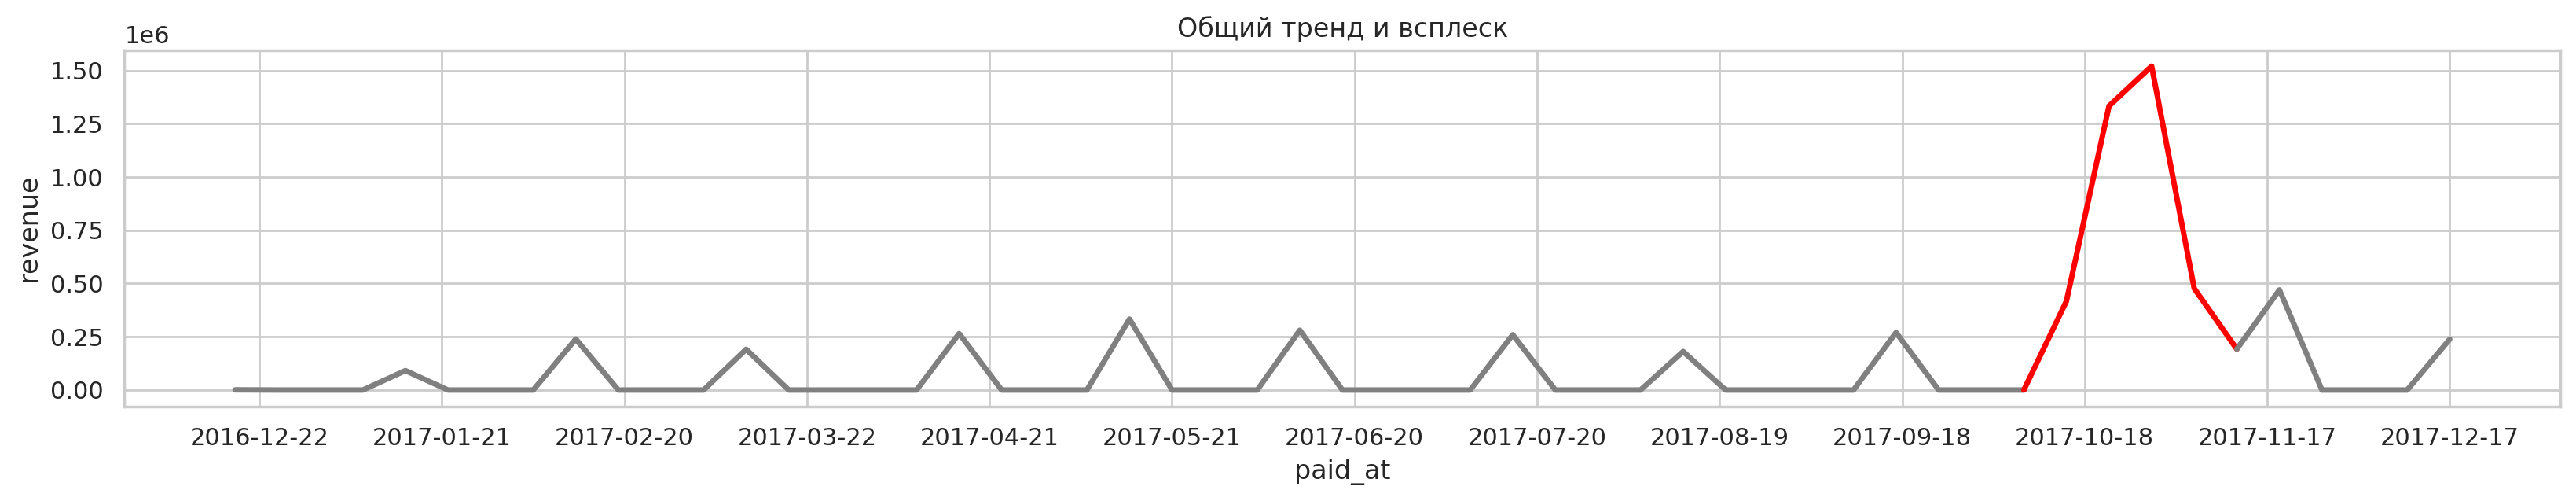

In [106]:
res = date_transactions.revenue.resample('W', level=0).sum().reset_index()
sns.set(rc={'figure.figsize':(20,3)}, style='whitegrid')
fig = plt.figure(dpi=200)
ax = sns.lineplot(x='paid_at',y='revenue',data=res[:43],color='grey',lw=2.5)
ax = sns.lineplot(x='paid_at',y='revenue',data=res[42:48],color='red',lw=2.5)
ax = sns.lineplot(x='paid_at',y='revenue',data=res[47:],color='grey',lw=2.5)
ax.xaxis.set_major_locator(ticker.MultipleLocator(30))
plt.title('Общий тренд и всплеск')
plt.show()

- ***проанализируем этот момент***

In [72]:
interesting_period = total_transactions[('2017-10-15 21:23:00' < total_transactions.paid_at)\
                                       &('2017-11-15 21:23:00' > total_transactions.paid_at)]

df1 = interesting_period.groupby(['country'])\
                  .agg({'revenue':'sum','uid': pd.Series.nunique})\
                  .sort_values('revenue',ascending=False).head(7)\

df2 = total_transactions.groupby('country')\
                  .agg({'revenue':'sum','uid': pd.Series.nunique})\
                  .sort_values('revenue',ascending=False).head(7)
                 

In [73]:
merge_df = df1.merge(df2,left_on='country', right_on='country',suffixes=('_by_period','_total'))
merge_df['%uid'] = round(merge_df['uid_by_period'].div(merge_df['uid_total'])*100,1)
merge_df['%revenue'] = round(merge_df['revenue_by_period'].div(merge_df['revenue_total'])*100,1)

In [74]:
merge_df[['uid_by_period','uid_total','%uid','revenue_by_period','revenue_total','%revenue']]\
        .style.format('${:.1f}', subset=['revenue_by_period','revenue_total'])\
        .format('{:.1f}', subset=['%uid','%revenue'])\
        .background_gradient(subset=['%uid','%revenue'], cmap='gist_yarg')

,uid_by_period,uid_total,%uid,revenue_by_period,revenue_total,%revenue
country,,,,,,
United States of America,112,176,63.6,$1254292.0,$2033967.0,61.7
Italy,23,42,54.8,$580918.0,$772200.0,75.2
Spain,23,36,63.9,$313625.0,$578266.0,54.2
France,32,54,59.3,$307723.0,$628602.0,49.0
United Arab Emirates,11,21,52.4,$293111.0,$406471.0,72.1
Argentina,17,29,58.6,$238875.0,$452465.0,52.8
United Kingdom (Great Britain),15,28,53.6,$216008.0,$372814.0,57.9


#### На "всплеск покупательской активности" приходится свыше 50% всех транзакций - с участием более 50% от общего числа всех пользователей. Природу данного явления установить не удается (нет данных) 

# Общие выводы:

- **ЕСЛИ ЦЕЛЬЮ ЭКСПЕРИМЕНТА БЫЛО УВЕЛИЧЕНИЕ КОНВЕРСИИ В PREMIUM - ОН НЕ УДАЛСЯ ;**
- **ПОЛОЖИТЕЛЬНОЕ ИЗМЕНЕНИЕ ПОКАЗАНИЙ МЕТРИК НАПРЯМУЮ СВЯЗАНО С РЕЗКИМ СКАЧКОМ АКТИВНОСТИ В ПЕРИОД   (с 2017-10-15 по 2017-11-15)  надо найти причину;** 

### Дополнительно: 
**установить зависимость между кол-вом coins и другими факторами не удалось, но тот факт, что 85% coin'ов в находятся в руках нашего** **соотечественника очень любопытен :-))**

In [75]:
(users_test[['uid','age','attraction_coeff','coins','country','was_premium','is_premium','total_revenue']]
    .query('uid in @interesting_users & coins > 0')
    .sort_values('coins',ascending=False)
    .style
    .format('${:.1f}', subset=['total_revenue'])
    .format('{:.0f}', subset=['was_premium','is_premium','coins']))

,uid,age,attraction_coeff,coins,country,was_premium,is_premium,total_revenue
597,891346269,34,204,530,Argentina,1,1,$75647.0
406,892236423,23,262,378,United States of America,1,1,$95823.0
476,891654090,29,326,248,United States of America,1,1,$38155.0
851,892186941,44,552,88,United States of America,1,1,$25207.0
1067,891986289,38,145,81,France,1,1,$31512.0
2642,892065108,99,475,72,France,1,1,$47242.0
100,891343671,26,0,24,France,1,1,$21580.0
3604,891603810,20,212,16,United States of America,1,1,$13702.0
1114,891222282,41,476,16,United States of America,1,1,$12597.0
446,891406224,25,212,10,Israel,1,1,$21645.0


In [104]:
(total_users.groupby(['country','uid'])
            .agg({'coins':'sum','total_revenue':'sum'})
            .reset_index()
            .query('coins >0')
            .sort_values('coins',ascending=False)
            .head(10)
            .style
            .format('{:.0f}', subset=['coins'])
            .highlight_max(subset='coins',color='#67C5EE'))

,country,uid,coins,total_revenue
6256,Russian Federation,960936960,99958,26
6254,Russian Federation,905158620,8466,0
5838,Italy,892333905,3608,486330
343,Argentina,891346269,530,75647
12247,United States of America,892236423,378,95823
4302,Germany,891664350,271,28119
11219,United States of America,891914619,253,35308
10439,United States of America,891654090,248,38155
972,Argentina,892150854,204,61789
4547,Germany,892248561,192,38779


In [77]:
print(f'{round(99958.0/total_users.coins.sum()*100,1)} %')

85.3 %
